In [40]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import pymc3 as pm
import colorsys


sys.path.append("../")
sys.path.append("../covid19_inference")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
from covid19_soccer.plot.other import get_alpha_infections
import covid19_inference as cov19
from covid19_inference.plot import _format_date_xticks

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
""" Matplotlib config
"""
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams["figure.figsize"] = [3.4, 2.7]  # APS single column
matplotlib.rcParams["figure.dpi"] = 300  # this primarily affects the size on screen
#matplotlib.rcParams['axes.linewidth'] = 0.3
matplotlib.rcParams["axes.labelcolor"] = "black"
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["xtick.color"] = "black"
matplotlib.rcParams["ytick.color"] = "black"
matplotlib.rcParams["xtick.labelsize"] = 8
matplotlib.rcParams["ytick.labelsize"] = 8
matplotlib.rcParams["axes.labelsize"] = 8
matplotlib.rcParams["axes.titlesize"]= 10
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["legend.title_fontsize"] = 8

""" Colors
Done with rcParams / see plot.rcParams
"""


""" General configs
"""
fig_path = "./figures"
country = "England"
xlim_ts = [datetime.datetime(2021,5,30),datetime.datetime(2021,7,23)] # Plotting range
tune = 200
draws = 300 
max_treedepth = 10
offset = 0 #offset of soccer games, mainly for sanity checks
width_prior_delay = 0.1

# Save figure as pdf and png        
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}

In [3]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
fstr=(f"/data.nst/jdehning/covid_uefa_traces11/UEFA"+
    f"-beta=False"+
    f"-country={country}"+
    f"-offset_data=0"+
    f"-draw_delay=True"+
    f"-weighted_alpha_prior=0"+
    f"-prior_delay=-1"+
    f"-width_delay_prior=0.1"+
    f"-sigma_incubation=-1.0"+
    f"-median_width_delay=1.0"+
    f"-interval_cps=10.0"+
    f"-tune={tune}"+
    f"-draws={draws}"+
    f"-max_treedepth={max_treedepth}.pickled")
model, trace = load(fstr)
dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])


### Without any soccer effect

In [4]:
trace_without_effect = trace.copy()
trace_without_effect.posterior["Delta_alpha_g_sparse"] = trace_without_effect.posterior["Delta_alpha_g_sparse"]*0
trace_without_effect.posterior["alpha_mean"] = trace_without_effect.posterior["alpha_mean"]*0
cases_without_effect = pm.fast_sample_posterior_predictive(trace_without_effect, model=model, var_names=['new_E_t', 'new_cases'], keep_size=True)

### With primary soccer infections
This requires to define a model to calculate the effect only the primary soccer related infections would have had on the measured cases

In [5]:

import theano.tensor as tt

from covid19_soccer.dataloader import Dataloader_gender, Dataloader
from covid19_soccer import delay_by_weekday
from covid19_soccer.utils import get_cps


from covid19_inference.model import (
    lambda_t_with_sigmoids,
    uncorrelated_prior_E,
    week_modulation,
    student_t_likelihood,
    delay_cases,
    Cov19Model,
    uncorrelated_prior_I,
    kernelized_spread,
    SIR,
)

def create_model_delay_only(
    dataloader=None,
    beta=True,
    use_gamma=False,
    draw_width_delay=True,
    use_weighted_alpha_prior=False,
    prior_delay=-1,
    width_delay_prior=0.1,
    sigma_incubation=-1,
    median_width_delay=1.0,
    interval_cps=10,
):
    """
    High level function to create an abstract pymc3 model using different defined
    model features. The default model is the main one described in our publication
    without any additionally modelled effect such as seasonality or temperature
    dependency.

    Parameters
    ----------
    dataloader : :class:`Dataloader`, optional
        Dataloader class for making the interaction with the data a lot
        easier. See `dataloader.py` for details. Even though the dataloader supports
        multiple countries you should only use a single one!
        Defaults to Scotland
    beta: bool
        Use beta model compartment
    use_gamma: bool
        Use gamma delay kernel

    Returns
    -------
    pymc3.Model

    """

    if dataloader is None:
        dl = Dataloader_gender(countries=["Scotland"])
    else:
        dl = dataloader

    if prior_delay == -1:
        if dl.countries[0] in ["Germany"]:
            prior_delay = 7
        elif dl.countries[0] in ["Scotland", "France", "England", "Netherlands"]:
            prior_delay = 4
        # elif dl.countries[0] in ["Portugal"]:
        # prior_delay = 5
        else:
            prior_delay = 5
            width_delay_prior = 0.15
            # raise RuntimeError("Country not known")

    # Median of the prior for the delay in case reporting, we assume 10 days
    default_interval = 10
    ratio_interval = interval_cps / default_interval
    cps_dict = dict(  # one possible change point every sunday
        relative_to_previous=True,
        pr_factor_to_previous=1.0,
        pr_sigma_transient_len=1 * ratio_interval,
        pr_median_transient_len=4 * ratio_interval,
        pr_sigma_date_transient=3.5 * ratio_interval,
    )

    # Change points every 10 days
    change_points = get_cps(
        dl.data_begin - datetime.timedelta(days=10),
        dl.data_end,
        interval=interval_cps,
        offset=5,
        **cps_dict,
    )

    if use_weighted_alpha_prior == 1:
        alpha_prior = dl.weighted_alpha_prior[0, :]
    elif use_weighted_alpha_prior == 0:
        alpha_prior = dl.alpha_prior[0, :]  # only select first country
    elif use_weighted_alpha_prior == -1:
        alpha_prior = 0.0
    else:
        raise RuntimeError(
            f"Unknown use_weighted_alpha_prior: {use_weighted_alpha_prior}"
        )

    if beta:
        beta_prior = dl.beta_prior[0, :]
        beta_weight = 1
        if (
            len(beta_prior[beta_prior > 0]) == 0
        ):  # No stadiums in home country -> don't use beta
            beta_prior = None
            stadium_size = None
    else:
        beta_prior = None
        beta_weight = None
        stadium_size = None

    # Construct model params dict
    params = {
        "new_cases_obs": dl.new_cases_obs[:, :, 0],  # only select first country
        "data_begin": dl.data_begin,
        "fcast_len": 16,
        "diff_data_sim": int((dl.data_begin - dl.sim_begin).days),
        "N_population": dl.population[:, 0],  # only select first country
    }
    with Cov19Model(**params) as this_model:
        new_cases = pm.Normal("new_E_t", 100, 1, shape=model.sim_shape)
        
        # Delay the cases by a log-normal reporting delay and add them as a trace variable
        new_cases = delay_cases(
            cases=new_cases,
            name_cases="delayed_cases",
            pr_mean_of_median=prior_delay,
            pr_sigma_of_median=width_delay_prior,
            pr_median_of_width=median_width_delay / 5 * prior_delay,
            pr_sigma_of_width=0.4 / 5 * prior_delay if draw_width_delay else None,
            seperate_on_axes=False,
            num_seperated_axes=2,  # num genders
            # num_variants=dl.nGenders,
            use_gamma=use_gamma,
            diff_input_output=0,
        )

        new_cases = delay_by_weekday.delay_cases_weekday(new_cases)

        # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
        # Also adds the "new_cases" variable to the trace that has all model features.
        weekend_factor_log = pm.Normal(
            name="weekend_factor_log", mu=tt.log(0.3), sigma=0.5,
        )
        weekend_factor = tt.exp(weekend_factor_log)
        new_cases = week_modulation(
            cases=new_cases,
            name_cases="new_cases",
            pr_mean_weekend_factor=weekend_factor,
        )

        # Define the likelihood, uses the new_cases_obs set as model parameter
        student_t_likelihood(cases=new_cases, sigma_shape=1)
    return this_model
model_new = create_model_delay_only(
    dataloader=dl,
    beta=False,
    use_gamma=True,
    draw_width_delay=True,
    use_weighted_alpha_prior=0,
    prior_delay=-1,
    width_delay_prior=0.1,
    sigma_incubation=-1.0,
    median_width_delay=1.0,
    interval_cps=10.0,
)


new_E_base, new_E_alpha = get_alpha_infections(trace, model, dl)
trace_primary_soccer = trace.copy()

# Summing the infectiouns without any soccer effect and the primary soccer infections
trace_primary_soccer.posterior["new_E_t"].values = cases_without_effect["new_E_t"]+new_E_alpha.reshape(cases_without_effect["new_E_t"].shape)
cases_primary_soccer = pm.fast_sample_posterior_predictive(trace_primary_soccer, model=model_new, var_names=['new_cases'], keep_size=True)

INFO     [covid19_soccer.utils] pr_sigma_lambda was set to default value 0.2
INFO     [covid19_soccer.utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_soccer.delay_by_weekday] Delaying cases by weekday
INFO     [covid19_inference.model.week_modulation] Week modulation


In [39]:
plt.plot(np.median(trace.posterior['new_cases'], axis=(0,1,3)))
plt.plot(np.median(cases_without_effect['new_cases'], axis=(0,1, 3)))
plt.plot(np.median(cases_primary_soccer['new_cases'], axis=(0,1, 3)))
plt.show()

<ipython-input-39-768c2fdc4880>:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [88]:
from covid19_inference.plot import _timeseries
from covid19_soccer.plot.utils import format_date_axis

def timeseries_filled(
    x,
    y,
    color,
    ax=None,
    date_format=True,
    alpha_ci=None,
    **kwargs,
):
    # ------------------------------------------------------------------------------ #
    # Default parameter
    # ------------------------------------------------------------------------------ #


    if ax is None:
        figure, ax = plt.subplots(figsize=(6, 3))


    # overwrite some styles that do not play well with fill_between
    if "linewidth" in kwargs:
        del kwargs["linewidth"]
    if "marker" in kwargs:
        del kwargs["marker"]
    kwargs["lw"] = 0
    
    median_y = np.median(y, axis=0)

    ax.fill_between(
        x,
        np.zeros_like(median_y),
        median_y,
        color=color,
        **kwargs,
    )
    # ------------------------------------------------------------------------------ #
    # formatting
    # ------------------------------------------------------------------------------ #
    if date_format:
        _format_date_xticks(ax)

    return ax


def plot_primary_vs_infection_chains(
    ax, y0, y1, y2, model, dl, ylim=None, color=None, color_data=None,
):
    """
    Plots incidence: modelfit and data
    """
    
    reshape_input = lambda var: var.reshape((var.shape[0] * var.shape[1],) + var.shape[2:])
    y0, y1, y2 = map(reshape_input, [y0, y1, y2])
    
    rcParams = covid19_soccer.plot.rcParams
    
    
    # Show time of uefa championship
    begin = datetime.datetime(2021, 6, 11)
    end = datetime.datetime(2021, 7, 11)
    ax.fill_betweenx(np.arange(0, 10000), begin, end, alpha=0.1)
    
    
    color2 = rcParams.color_model
    
    h, l, s = colorsys.rgb_to_hls(*mpl.colors.to_rgb(color2))
    # manipulate h, l, s values and return as rgb
    scale0 = 0.4
    scale1 = 0.6    
    color0 = colorsys.hls_to_rgb(h, min(1, l * scale0), s = s)
    color1 = colorsys.hls_to_rgb(h, min(1, l * scale1), s = s)
    
    # Plot three different incidences
    
    timeseries_filled(
        x=pd.date_range(model.sim_begin, model.sim_end),
        y=(y2[:, :, 0] + y2[:, :, 1])
        / (dl.population[0, 0] + dl.population[1, 0])
        * 1e6,  # incidence
        ax=ax,
        color=color2,
        label="b"
    )
    timeseries_filled(
        x=pd.date_range(model.sim_begin, model.sim_end),
        y=(y1[:, :, 0] + y1[:, :, 1])
        / (dl.population[0, 0] + dl.population[1, 0])
        * 1e6,  # incidence
        ax=ax,
        color=color1,
        label='c'
    )
    timeseries_filled(
        x=pd.date_range(model.sim_begin, model.sim_end),
        y=(y0[:, :, 0] + y0[:, :, 1])
        / (dl.population[0, 0] + dl.population[1, 0])
        * 1e6,  # incidence
        ax=ax,
        color=color0,
        label='d'
    )
    

    
    

    # Plot data
    data_points = (
        (dl.new_cases_obs[:, 0, 0] + dl.new_cases_obs[:, 1, 0])
        / (dl.population[0, 0] + dl.population[1, 0])
        * 1e6
    )
    _timeseries(
        x=pd.date_range(model.data_begin, model.data_end),
        y=data_points,
        what="data",
        ax=ax,
        color=rcParams.color_data if color_data is None else color_data,
        ms=1.5,
        alpha=0.8,
        label='e'
    )



    # Adjust ylim
    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim(0, data_points.max() + data_points.max() / 8)

    # Markup
    ax.set_ylabel("Incidence")
    format_date_axis(ax)

    return ax


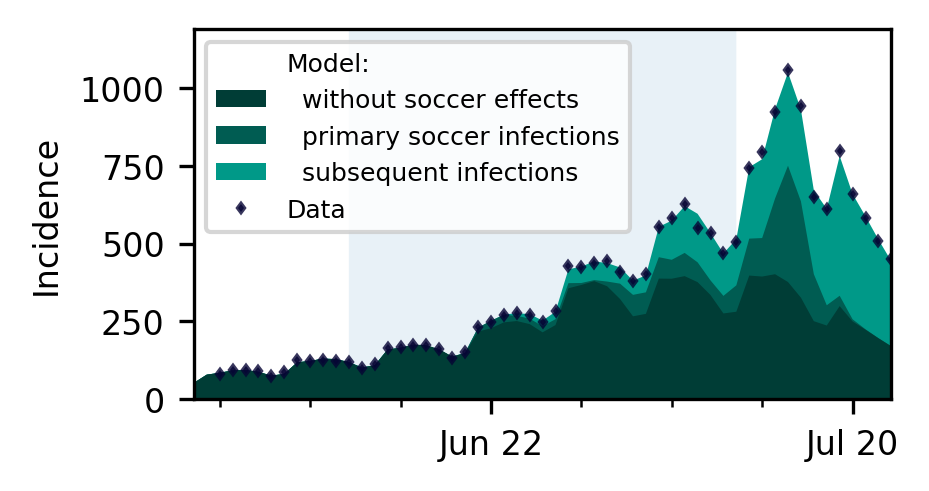

In [101]:
fig, ax = plt.subplots(figsize=(3,1.6))
ax.plot([], [], alpha=0, label="a")


plot_primary_vs_infection_chains(ax,
                                 cases_without_effect['new_cases'],
                                 cases_primary_soccer['new_cases'],
                                 trace.posterior['new_cases'].values,
                                 model, dl)

handles, _ = ax.get_legend_handles_labels()
order = [0,4,3,2,1]
ax.set_xlim(*xlim_ts)

ax.legend([handles[idx] for idx in order],["Model:","  without soccer effects", "  primary soccer infections", "  subsequent infections", "Data"])

plt.show()
fig.savefig(f"{fig_path}/primary_vs_infections_chains_{country}.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/primary_vs_infections_chains_{country}.pdf", **save_kwargs)

In [65]:
handles, _ = ax.get_legend_handles_labels()
_

[]

In [90]:
handles